In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
def goes16_earth_coordinates(x,y):
    """
    From the GOES16 fixed grid to the Earth coordinates in degrees.
    """
    req = 6378137 # m
    rpol = 6356752.31414 # m
    H = 42164160 # m
    lambda0 = -1.308996939 # rad

    a = np.sin(x)**2+np.cos(x)**2*(np.cos(y)**2+req**2*np.sin(y)**2/rpol**2) 
    b = -2*H*np.cos(x)*np.cos(y)
    c = H**2-req**2

    rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)

    sx = rs*np.cos(x)*np.cos(y)
    sy = -rs*np.sin(x)
    sz = rs*np.cos(x)*np.sin(y)

    lat = np.arctan(req**2*sz/(rpol**2*np.sqrt((H-sx)**2+sy**2)))
    lon = lambda0-np.arctan(sy/(H-sx))

    return lon*180/np.pi, lat*180/np.pi

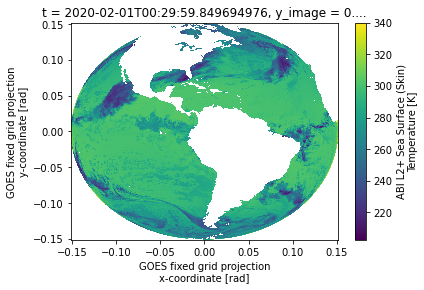

In [4]:
path2GOES = '/home/agostino/SST-impact_data/'
filename = 'OR_ABI-L2-SSTF-M6_G16_s20200320000144_e20200320059452_c20200320106148.nc'
ds = xr.open_dataset(path2GOES+filename)
ds['SST'].plot()

In [5]:
print(ds.t)
ds

<xarray.DataArray 't' ()>
array('2020-02-01T00:29:59.849694976', dtype='datetime64[ns]')
Coordinates:
    t                                datetime64[ns] 2020-02-01T00:29:59.84969...
    y_image                          float32 ...
    x_image                          float32 ...
    retrieval_local_zenith_angle     float32 ...
    quantitative_local_zenith_angle  float32 ...
    retrieval_solar_zenith_angle     float32 ...
    day_solar_zenith_angle           float32 ...
    night_solar_zenith_angle         float32 ...
Attributes:
    long_name:      J2000 epoch mid-point between the start and end image sca...
    standard_name:  time
    axis:           T
    bounds:         time_bounds


<xarray.Dataset>
Dimensions:                                                 (SST_day_night_emissive_bands: 4, SST_night_only_emissive_band: 1, number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, x: 5424, y: 5424)
Coordinates: (12/14)
    t                                                       datetime64[ns] 20...
  * y                                                       (y) float32 0.151...
  * x                                                       (x) float32 -0.15...
    y_image                                                 float32 ...
    x_image                                                 float32 ...
    retrieval_local_zenith_angle                            float32 ...
    ...                                                      ...
    day_solar_zenith_angle                                  float32 ...
    night_solar_zenith_angle                                float32 ...
    SST_night_only_emissive_wavelength                      (SST_night_only_emissive_band) float32 ...
    SST_day_night_emissive_wavelengths                      (SST_day_night_emissive_bands) float32 ...
    SST_night_only_emissive_band_id                         (SST_night_only_emissive_band) int8 ...
    SST_day_night_emissive_band_ids                         (SST_day_night_emissive_bands) int8 ...
Dimensions without coordinates: SST_day_night_emissive_bands, SST_night_only_emissive_band, number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables: (12/42)
    SST                                                     (y, x) float32 ...
    DQF                                                     (y, x) float32 ...
    time_bounds                                             (number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                                  int32 ...
    y_image_bounds                                          (number_of_image_bounds) float32 ...
    x_image_bounds                                          (number_of_image_bounds) float32 ...
    ...                                                      ...
    retrieval_solar_zenith_angle_bounds                     (number_of_SZA_bounds) float32 ...
    day_solar_zenith_angle_bounds                           (number_of_SZA_bounds) float32 ...
    night_solar_zenith_angle_bounds                         (number_of_SZA_bounds) float32 ...
    twilight_solar_zenith_angle_bounds                      (number_of_SZA_bounds) float32 ...
    percent_uncorrectable_GRB_errors                        float32 ...
    percent_uncorrectable_L0_errors                         float32 ...
Attributes: (12/34)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    long_name:                 standard deviation of the difference of the ob...
    _FillValue:                -999.0
    units:                     K
    grid_mapping:              goes_imager_projection
    cell_methods:              quantitative_local_zenith_angle: sum retrieval...
    id:                        8d004483-946b-406d-8c1c-cfd08bd471fb

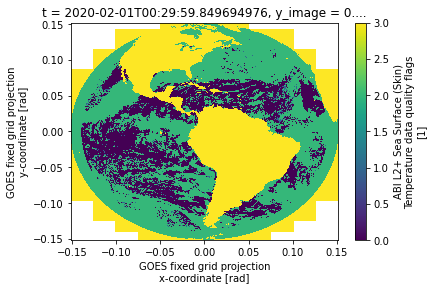

In [6]:
ds.DQF.plot()

In [8]:
x = ds.x.values
y = ds.y.values

xx, yy = np.meshgrid(x,y)

lon, lat = goes16_earth_coordinates(xx,yy)

<ipython-input-3-c20ef078cd96>:14: RuntimeWarning: invalid value encountered in sqrt
  rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)


In [10]:
def crop_field(field,lon,lat,area):
    """
    Function to crop a 2d field over the area specified by the list
    area = [minlon,maxlon,minlat,maxlat]
    """
    valid_indices = np.argwhere((lon>area[0])&(lon<area[1])&(lat>area[2])&(lat<area[3]))
    x_min, y_min = valid_indices.min(axis=0)
    x_max, y_max = valid_indices.max(axis=0)
    return field[x_min:x_max+1, y_min:y_max+1]

<ipython-input-23-7af7957fdc82>:20: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(pc)


Text(0.5, 1.0, '2020-02-01T00:29:59.849694976')

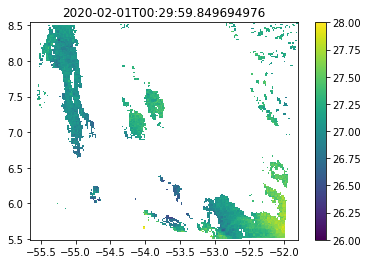

In [23]:
sst = ds.SST.values
dqf = ds.DQF.values

minlon = -55.5; maxlon = -52.; minlat = 5.5; maxlat = 8.5; 
sst_vmin = 26.; sst_vmax = 28.

extent_param = [minlon, maxlon, minlat, maxlat]

sst_crop = crop_field(sst,lon,lat,extent_param)
lon_crop = crop_field(lon,lon,lat,extent_param)
lat_crop = crop_field(lat,lon,lat,extent_param)
dqf_crop = crop_field(dqf,lon,lat,extent_param)
dqf_mask = dqf_crop+1 # Select only values that are == 0 in the original DQF field.
dqf_mask[dqf_mask!=1]=np.nan

plt.pcolormesh(lon_crop,lat_crop,(sst_crop-273.15)*dqf_mask,shading='nearest',vmin=sst_vmin,vmax=sst_vmax)

#pc = plt.scatter(lon_crop[dqf_crop==0],lat_crop[dqf_crop==0],c=sst_crop[dqf_crop==0]-273.15,marker='.',
#                vmin=sst_vmin,vmax=sst_vmax)
plt.colorbar(pc)
plt.title(ds.t.values)

In [33]:
# Test points
x = -0.024052 #ds.x.values
y = 0.095340 #ds.y.values

# Compute the lon-lat coordinates.
req = 6378137 # m
rpol = 6356752.31414 # m
H = 42164160 # m
lambda0 = -1.308996939 # rad

a = np.sin(x)**2+np.cos(x)**2*(np.cos(y)**2+req**2*np.sin(y)**2/rpol**2) 
b = -2*H*np.cos(x)*np.cos(y)
c = H**2-req**2

rs = (-b-np.sqrt(b**2-4*a*c))/(2*a)

sx = rs*np.cos(x)*np.cos(y)
sy = -rs*np.sin(x)
sz = rs*np.cos(x)*np.sin(y)

lat = np.arctan(req**2*sz/(rpol**2*np.sqrt((H-sx)**2+sy**2)))
lon = lambda0-np.arctan(sy/(H-sx))
print(lon*180/np.pi)
print(lat*180/np.pi)

-84.69093211900741
33.84616229060915


In [32]:
print(a)
print(b)
print(c)
print(rs)
print(sx)
print(sy)
print(sz)

1.0000610393966292
-83921070.03211282
1737135756914831
37116295.874486506
36937048.733040124
892635.0778582101
3532287.212730611


In [37]:
lon,lat = goes16_earth_coordinates(-0.024052,0.095340)
print(lon)
print(lat)

-84.69093211900741
33.84616229060915
